In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from matplotlib import gridspec
import imageio
from IPython.display import Video

from src.encoder_temporal import VICRegJEPAEncoder
from src.data.dataset import PointMazeTransitions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Load the dataset

In [2]:
dataset = PointMazeTransitions(
    "data/train_trajectories_10_100_4_64.npz",
    normalize=True,
)

[Dataset] Frames resized to 64×64
[Dataset] Loaded 10 episodes, 1000 transitions.
[Dataset] Frame shape: (64, 64, 3)


Load the model

In [3]:
visual_encoder = VICRegJEPAEncoder.load_from_checkpoint("checkpoints/visual_encoder/last.ckpt", strict=False)
visual_encoder.to(device)
visual_encoder.eval();

In [4]:
save_nets = False
if save_nets:
    base_path = "checkpoints/pth/"
    torch.save(visual_encoder.visual_encoder.state_dict(), base_path + "visual_encoder.pth")
    torch.save(visual_encoder.proprio_encoder.state_dict(), base_path + "proprio_encoder.pth")
    torch.save(visual_encoder.visual_decoder.state_dict(), base_path + "visual_decoder.pth")
    torch.save(visual_encoder.proprio_decoder.state_dict(), base_path + "proprio_decoder.pth")

Encoding decoding

In [5]:
idx = 1

In [6]:
(proprio_curr, img_curr), action, (proprio_next, img_next), _ = dataset[idx]

with torch.no_grad():
    # move inputs to device and use bfloat16 autocast for enc/dec
    with torch.amp.autocast(dtype=torch.bfloat16, device_type=device.type):
        p_curr = proprio_curr.unsqueeze(0).to(device)
        p_next = proprio_next.unsqueeze(0).to(device)
        i_curr = img_curr.unsqueeze(0).to(device)
        i_next = img_next.unsqueeze(0).to(device)

        z_proprio_curr = visual_encoder.proprio_encoder(p_curr)
        z_cls_curr, z_patches_curr, _ = visual_encoder.visual_encoder(i_curr)

        z_proprio_next = visual_encoder.proprio_encoder(p_next)
        z_cls_next, z_patches_next, _ = visual_encoder.visual_encoder(i_next)

        proprio_curr_recon = visual_encoder.proprio_decoder(z_proprio_curr).float().cpu().squeeze(0).float().cpu().squeeze(0)
        img_curr_recon = visual_encoder.visual_decoder(z_patches_curr).float().cpu().squeeze(0).float().cpu().squeeze(0)

        proprio_next_recon = visual_encoder.proprio_decoder(z_proprio_next).float().cpu().squeeze(0).float().cpu().squeeze(0)
        img_next_recon = visual_encoder.visual_decoder(z_patches_next).float().cpu().squeeze(0).float().cpu().squeeze(0)

        action_encoded = visual_encoder.action_encoder(action.unsqueeze(0).to(device))
        action_pred_cls = visual_encoder.idm_visual(torch.cat([z_cls_curr, z_cls_next], dim=1)).float().cpu().squeeze(0)
        action_pred_state = visual_encoder.idm_proprio(torch.cat([z_proprio_curr, z_proprio_next], dim=1)).float().cpu().squeeze(0)

W1109 17:22:57.692000 156297 site-packages/torch/_inductor/utils.py:1436] [1/0] Not enough SMs to use max_autotune_gemm mode
E1109 17:23:03.617000 156297 site-packages/torch/_subclasses/fake_tensor.py:2721] [3/0] failed while attempting to run meta for aten.view.default
E1109 17:23:03.617000 156297 site-packages/torch/_subclasses/fake_tensor.py:2721] [3/0] Traceback (most recent call last):
E1109 17:23:03.617000 156297 site-packages/torch/_subclasses/fake_tensor.py:2721] [3/0]   File "/home/gabrielepintus/.conda/envs/py12/lib/python3.12/site-packages/torch/_subclasses/fake_tensor.py", line 2717, in _dispatch_impl
E1109 17:23:03.617000 156297 site-packages/torch/_subclasses/fake_tensor.py:2721] [3/0]     r = func(*args, **kwargs)
E1109 17:23:03.617000 156297 site-packages/torch/_subclasses/fake_tensor.py:2721] [3/0]         ^^^^^^^^^^^^^^^^^^^^^
E1109 17:23:03.617000 156297 site-packages/torch/_subclasses/fake_tensor.py:2721] [3/0]   File "/home/gabrielepintus/.conda/envs/py12/lib/pytho

TorchRuntimeError: Dynamo failed to run FX node with fake tensors: call_method view(*(FakeTensor(..., device='cuda:0', size=(1, 225, 192), dtype=torch.bfloat16), 1, 8, 8, 3, 8, 8), **{}): got RuntimeError("shape '[1, 8, 8, 3, 8, 8]' is invalid for input of size 43200")

from user code:
   File "/home/gabrielepintus/Documents/github/JEPA-Thesis/src/components/decoder.py", line 86, in forward
    x = x.view(

Set TORCHDYNAMO_VERBOSE=1 for the internal stack trace (please do this especially if you're reporting a bug to PyTorch). For even more developer context, set TORCH_LOGS="+dynamo"


Current Proprioception:
tensor([-0.3599, -0.2113, -0.3515,  0.3733])
tensor([-0.4062, -0.2188, -0.3828,  0.4688])
Error: 45.0 10^-3

Next Proprioception:
tensor([-0.3880, -0.1806, -0.3665,  0.3939])
tensor([-0.4336, -0.1953, -0.3887,  0.4883])
Error: 44.0 10^-3

Action error:
From cls:	 432.0 10^-6
From state:	 492.0 10^-6


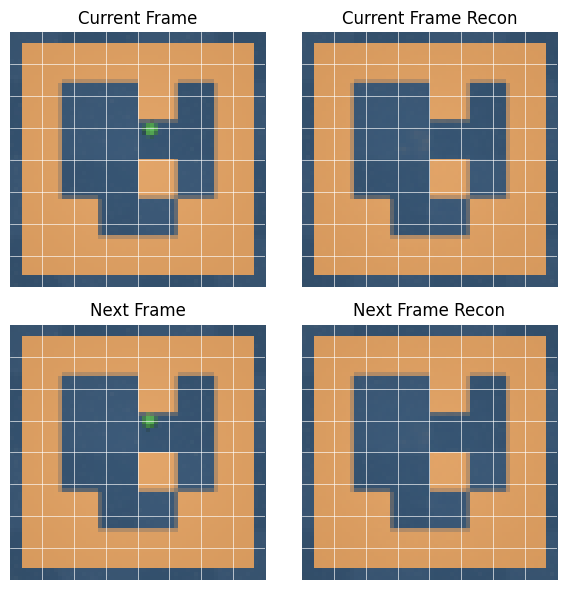

In [ ]:
print("Current Proprioception:")
print(proprio_curr)
print(proprio_curr_recon)
print("Error:", (torch.abs(proprio_curr - proprio_curr_recon).mean() * 1e3).round().item(), "10^-3")
print("\nNext Proprioception:")
print(proprio_next)
print(proprio_next_recon)
print("Error:", (torch.abs(proprio_next - proprio_next_recon).mean() * 1e3).round().item(), "10^-3")
print("\nAction error:")
ae = action_encoded.cpu().float()
apc = action_pred_cls.cpu().float()
aps = action_pred_state.cpu().float()

print("From cls:\t", (torch.abs(ae - apc).mean() * 1e6).round().item(), "10^-6")
print("From state:\t", (torch.abs(ae - aps).mean() * 1e6).round().item(), "10^-6")

fig, axs = plt.subplots(2, 2, figsize=(6, 6))

def _to_np_img(t):
    t = t.detach().cpu()
    if t.ndim == 4 and t.shape[0] == 1:
        t = t.squeeze(0)
    if t.shape[0] in (1, 3):
        return t.permute(1, 2, 0).numpy()
    return t.numpy()

def imshow_with_grid(ax, tensor_img, title, step=8):
    img = _to_np_img(tensor_img)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")
    # draw 8x8 grid for 64x64 images (lines every 8 pixels)
    step = 64 // step
    positions = np.arange(step, 64, step)
    # choose contrasting color based on mean brightness
    mean_brightness = img.mean()
    line_color = 'white' if mean_brightness < 0.5 else 'black'
    for p in positions:
        ax.axvline(p - 0.5, color=line_color, linewidth=0.5, alpha=0.9)
        ax.axhline(p - 0.5, color=line_color, linewidth=0.5, alpha=0.9)

STEP = 8
imshow_with_grid(axs[0, 0], img_curr, "Current Frame", step=STEP)
imshow_with_grid(axs[0, 1], img_curr_recon, "Current Frame Recon", step=STEP)
imshow_with_grid(axs[1, 0], img_next, "Next Frame", step=STEP)
imshow_with_grid(axs[1, 1], img_next_recon, "Next Frame Recon", step=STEP)

plt.tight_layout()
plt.show()

In [23]:
def focal_mse(pred, target, gamma=2):
    err = (pred - target)
    return ((err.abs() ** gamma) * (err ** 2))

def l2_image(tensor_img1, tensor_img2):
    return (tensor_img1-tensor_img2).pow(2)

In [24]:
err1 = l2_image(img_curr, img_curr_recon.cpu()).mean(0)
err2 = focal_mse(img_curr, img_curr_recon.cpu(), gamma=2).mean(0)
alpha = 5e-1
err3 = (err1*alpha + err2*(1-alpha))

In [25]:
err1.mean(), err2.mean()

(tensor(8.8296e-05), tensor(5.5163e-06))

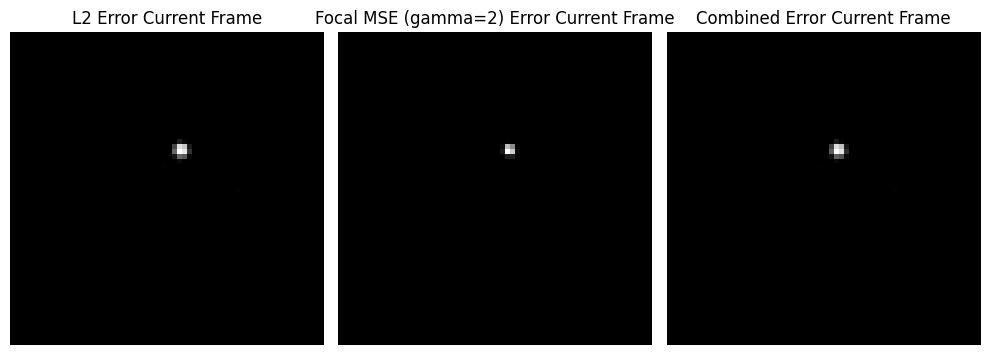

In [26]:
err3 = (err3 - err3.min()) / (err3.max() - err3.min())

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(_to_np_img(err1), cmap='gray')
axs[0].set_title("L2 Error Current Frame")
axs[0].axis("off")
axs[1].imshow(_to_np_img(err2), cmap='gray')
axs[1].set_title("Focal MSE (gamma=2) Error Current Frame")
axs[1].axis("off")
axs[2].imshow(_to_np_img(err3), cmap='gray')
axs[2].set_title("Combined Error Current Frame")
axs[2].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
batch = torch.stack([img_curr, img_next], dim=0)  # (B, 3, 64, 64)
batch_pred = torch.stack([img_curr_recon, img_next_recon], dim=0)  # (B, 3, 64, 64)

In [ ]:
(batch - batch_pred).mean(1).shape

In [ ]:
def patch_weighted_recon_loss(pred, target, patch_size=8, eps=1e-6):
    B, C, H, W = pred.shape
    ph = H // patch_size
    pw = W // patch_size

    # reshape into patches
    pred_p = pred.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)  # (B,C,ph,pw,P,P)
    tgt_p  = target.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)

    mse_per_patch = ((pred_p - tgt_p) ** 2).mean(dim=(1,5,6))        # (B, ph, pw)

    # normalize weights between patches within each image
    weights = mse_per_patch / (mse_per_patch.sum(dim=(1,2), keepdim=True) + eps)

    # weighted sum of per-patch MSE
    loss = (weights * mse_per_patch).sum(dim=(1,2))                  # (B,)
    return loss.mean()

In [ ]:
diff = (z_patches_next - z_patches_curr)[0].abs().cpu().detach().numpy().mean(axis=1)
# softmax with temperature T
T = .5
diff = np.exp(diff / T) / np.sum(np.exp(diff / T))
# get first k indices with highest difference
k = 2
topk_indices = np.argsort(-diff)[:k]
print(f"Top {k} patches with highest difference indices: {topk_indices}")
print(f"Values: {diff[topk_indices].sum():.1%}")
# normalize for better visualization
plt.figure(figsize=(4, 3))
plt.title("Patch Differences between Current and Next Frame")
plt.bar(np.arange(len(diff)), diff)
plt.xlabel("Patch Index")
plt.ylabel("Mean Absolute Difference")
plt.show()

Define helpful methods

In [ ]:
def show_reconstruction(idx):
    # Load data
    (proprio_curr, img_curr), action, (proprio_next, img_next), _ = dataset[idx]
    
    # Prepare inputs
    imgs = {
        'curr': img_curr.unsqueeze(0).to(device),
        'next': img_next.unsqueeze(0).to(device)
    }
    proprios = {
        'curr': proprio_curr.unsqueeze(0).to(device),
        'next': proprio_next.unsqueeze(0).to(device)
    }
    action = action.unsqueeze(0).to(device)
    
    # Run inference
    with torch.no_grad():
        encodings = _encode_states(imgs, proprios)
        reconstructions = _reconstruct_states(encodings)
        predictions = _predict_next_state(encodings, action)
    
    # Display results
    _print_proprio_table(proprios, reconstructions)
    _plot_images(imgs, reconstructions, predictions)

    return encodings, reconstructions, predictions


def _encode_states(imgs, proprios):
    """Encode visual and proprioceptive states."""
    with torch.amp.autocast(dtype=torch.bfloat16, device_type=device.type):
        cls_curr, patches_curr, _ = visual_encoder.visual_encoder(imgs['curr'])
        cls_next, patches_next, _ = visual_encoder.visual_encoder(imgs['next'])
    
    return {
        'cls_curr': cls_curr,
        'patches_curr': patches_curr,
        'cls_next': cls_next,
        'patches_next': patches_next,
        'proprio_curr': visual_encoder.proprio_encoder(proprios['curr']),
        'proprio_next': visual_encoder.proprio_encoder(proprios['next'])
    }


def _reconstruct_states(enc):
    """Reconstruct states from encodings."""
    return {
        'img_curr': visual_encoder.visual_decoder(enc['patches_curr'], enc['cls_curr'], enc['proprio_curr']),
        'img_next': visual_encoder.visual_decoder(enc['patches_next'], enc['cls_next'], enc['proprio_next']),
        'proprio_curr': visual_encoder.proprio_decoder(enc['proprio_curr']),
        'proprio_next': visual_encoder.proprio_decoder(enc['proprio_next']),
        'proprio_from_cls_curr': visual_encoder.proprio_decoder(enc['cls_curr']),
        'proprio_from_cls_next': visual_encoder.proprio_decoder(enc['cls_next'])
    }


def _predict_next_state(enc, action):
    """Predict next state from current state and action."""
    with torch.amp.autocast(dtype=torch.bfloat16, device_type=device.type):
        # tokens = torch.cat([enc['cls_curr'].unsqueeze(1), enc['patches_curr']], dim=1)
        action_enc = visual_encoder.action_encoder(action)
        
        # pred_cls, pred_patches, pred_prop = visual_encoder.predictor(
        #     tokens, enc['proprio_curr'], action_enc
        # )
        pred_cls, pred_patches, pred_prop = visual_encoder.predictor(
            enc['patches_curr']
        )
        # pred_cls += enc['cls_curr']
        # pred_patches += enc['patches_curr']
        # pred_prop += enc['proprio_curr']

    with torch.amp.autocast(dtype=torch.bfloat16, device_type=device.type):
        return {
            'cls': visual_encoder.proprio_decoder(pred_cls).float(),
            'proprio': visual_encoder.proprio_decoder(pred_prop).float(),
            'img': visual_encoder.visual_decoder(pred_patches, pred_cls, pred_prop).float()
        }


def _print_proprio_table(proprios, recons):
    """Display proprioceptive data in a table."""
    fmt = lambda x: np.array2string(x.cpu().numpy(), precision=3, suppress_small=True)
    
    table = [
        ["", "Original", "Reconstructed (proprio)", "Reconstructed (visual cls)"],
        ["Current", fmt(proprios['curr']), fmt(recons['proprio_curr']), 
         fmt(recons['proprio_from_cls_curr'])],
        ["Next", fmt(proprios['next']), fmt(recons['proprio_next']), 
         fmt(recons['proprio_from_cls_next'])]
    ]
    
    table_transposed = list(map(list, zip(*table)))
    print(tabulate(table_transposed, headers="firstrow", tablefmt="fancy_grid"))


def _plot_images(imgs, recons, preds):
    """Plot original, reconstructed, and predicted images."""
    to_img = lambda x: x[0].permute(1, 2, 0).cpu()
    
    _, axes = plt.subplots(2, 3, figsize=(10, 6))
    
    # Current state row
    axes[0, 0].imshow(to_img(imgs['curr']))
    axes[0, 0].set_title("Current")
    
    axes[0, 1].imshow(to_img(recons['img_curr']))
    axes[0, 1].set_title("Reconstruction")
    
    axes[0, 2].imshow(torch.ones_like(imgs['curr'])[0].permute(1, 2, 0).cpu())
    axes[0, 2].set_title("White")
    
    # Next state row
    axes[1, 0].imshow(to_img(imgs['next']))
    axes[1, 0].set_title("Next")
    
    axes[1, 1].imshow(to_img(recons['img_next']))
    axes[1, 1].set_title("Reconstruction")
    
    axes[1, 2].imshow(to_img(preds['img']))
    axes[1, 2].set_title("Predicted Next")
    
    for ax in axes.flat:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

In [ ]:
encodings, reconstructions, predictions = show_reconstruction(11)

In [ ]:
diff = encodings['patches_next'][0] - encodings['patches_curr'][0]
diff = torch.round(diff, decimals=2)

# Get the top-k changing patches
K = 6
patch_changes = diff.abs().mean(dim=-1)  # (N,)
_, topk_indices = torch.topk(patch_changes, k=K, dim=-1)  # (k,)
plt.figure(figsize=(12, 3))
plt.imshow(diff.cpu().numpy().round(1).T, cmap='bwr', aspect='auto')
plt.colorbar()
plt.title("Top-K Changing Patches Highlighted")
for idx in topk_indices:
    plt.axvline(x=idx.item(), color='k', linestyle='--')
plt.show()

patch_changes_grid = patch_changes.view(8, 8)
plt.figure(figsize=(6, 6))
plt.imshow(patch_changes_grid.cpu().numpy().round(2), cmap='plasma')
plt.colorbar()
plt.title("Patch Changes Magnitude")
plt.show()

In [ ]:
plt.figure(figsize=(12, 3))
plt.imshow(diff.cpu().numpy().round(1).T, cmap='bwr', aspect='auto')
plt.colorbar()
plt.title("Min-Max Normalized Difference between Next and Current Patch Encodings")
plt.show()

In [ ]:
# Extract a trajectory
horizon = 80
trajectory = [
    dataset[idx][0] for idx in range(horizon)
]

# Compute all the embeddings
proprio_traj = []
cls_traj = []
patches_traj = []
recon_traj = []
with torch.no_grad():
    for (proprio, img) in trajectory:
        img = img.unsqueeze(0).to(device)
        proprio = proprio.unsqueeze(0).to(device)
        with torch.amp.autocast(dtype=torch.float16, device_type=device.type):
            cls, patches, _ = visual_encoder.visual_encoder(img)
            recon = visual_encoder.visual_decoder(patches)
        proprio_traj.append(proprio.cpu())
        cls_traj.append(cls.cpu())
        patches_traj.append(patches.cpu())
        recon_traj.append(recon.cpu())

# Stack
proprio_traj = torch.cat(proprio_traj, dim=0)   # (horizon, D)
cls_traj = torch.cat(cls_traj, dim=0)           # (horizon, E)
patches_traj = torch.cat(patches_traj, dim=0)   # (horizon, P)
recon_traj = torch.cat(recon_traj, dim=0)       # (horizon, P)

In [ ]:
from sklearn.manifold import TSNE

def twoD_projection(cls_traj):
    tsne = TSNE(n_components=2, perplexity=10, random_state=0)
    return tsne.fit_transform(cls_traj.numpy())

cls_traj_2d = twoD_projection(cls_traj)

In [ ]:
from IPython.display import HTML, display

# Write a practically lossless MP4 for reconstructions (images)
mp4_path = "reconstructed_trajectory_lossless.mp4"
fps = 3

with imageio.get_writer(
    mp4_path,
    fps=fps,
    codec='libx264',
    ffmpeg_params=['-crf', '0', '-preset', 'veryslow', '-pix_fmt', 'yuv444p']
) as writer:
    for t in range(horizon):
        img = recon_traj[t].permute(1,2,0).cpu().float().numpy()   # (H, W, 3), float [0,1]
        img = (img * 255).astype(np.uint8)
        writer.append_data(img)


# Create a video rendering the 2D latent trajectory (rendered with matplotlib)
mp4_path_latent = "reconstructed_trajectory_latent.mp4"

# ensure cls_traj_2d is a numpy array
if not isinstance(cls_traj_2d, np.ndarray):
    cls_xy = cls_traj_2d.cpu().numpy()
else:
    cls_xy = cls_traj_2d

with imageio.get_writer(
    mp4_path_latent,
    fps=fps,
    codec='libx264',
    ffmpeg_params=['-crf', '0', '-preset', 'veryslow', '-pix_fmt', 'yuv444p']
) as writer:
    fig, ax = plt.subplots(figsize=(6,6))
    xmin, xmax = cls_xy[:,0].min(), cls_xy[:,0].max()
    ymin, ymax = cls_xy[:,1].min(), cls_xy[:,1].max()
    # add small padding
    dx = (xmax - xmin) * 0.05 if xmax > xmin else 0.1
    dy = (ymax - ymin) * 0.05 if ymax > ymin else 0.1
    for t in range(horizon):
        ax.clear()
        # faint trajectory line
        ax.plot(cls_xy[:,0], cls_xy[:,1], color='lightgray', linewidth=1, zorder=1)
        # colored points
        ax.scatter(cls_xy[:,0], cls_xy[:,1], c=np.arange(len(cls_xy)), cmap='plasma', s=40, zorder=2)
        # highlight current timestep
        ax.scatter([cls_xy[t,0]], [cls_xy[t,1]], color='red', s=120, zorder=3)
        ax.set_xlim(xmin - dx, xmax + dx)
        ax.set_ylim(ymin - dy, ymax + dy)
        ax.set_title(f"Latent Trajectory (t={t})")
        ax.axis('off')
        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        frame = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8).reshape(h, w, 4)
        writer.append_data(frame)
    plt.close(fig)

In [ ]:
html = f"""
<div style="display:flex;gap:12px;align-items:flex-start">
  <div style="flex:0 0 auto;text-align:center">
    <div>Reconstructed Images</div>
    <video src="{mp4_path}" controls style="min-width:240px; max-width:240px; height:auto;"></video>
  </div>
  <div style="flex:0 0 auto;text-align:center">
    <div>Latent Trajectory</div>
    <video src="{mp4_path_latent}" controls style="min-width:240px; max-width:240px; height:auto;"></video>
  </div>
</div>
"""
display(HTML(html))

In [ ]:
cls_traj_2d = twoD_projection(cls_traj)
idxs = np.arange(cls_traj_2d.shape[0])

plt.figure(figsize=(6,6))
# faint line connecting points
plt.plot(cls_traj_2d[:,0], cls_traj_2d[:,1], color='lightgray', linewidth=1, zorder=1)
# colored points showing order
sc = plt.scatter(cls_traj_2d[:,0], cls_traj_2d[:,1], c=idxs, cmap='plasma', s=60, zorder=2)
plt.colorbar(sc, label='timestep')
# optional labels (can remove if cluttered)
for i in range(0, cls_traj_2d.shape[0], 5):
    plt.annotate(
        str(i),
        (cls_traj_2d[i,0], cls_traj_2d[i,1]),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold',
        # ha='right',
        # va='bottom',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
    )

plt.title("Trajectory in Visual CLS Embedding Space (2D Projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

rollout

In [ ]:
# multi step rollout from a real trajectory autoregressive predictions
horizon = 50
start_idx = 10
true_proprio, decoded_predicted_proprio = [], []
true_img, decoded_predicted_img = [], []
with torch.no_grad():
    # initialize with true state
    proprio = trajectory[start_idx][0].unsqueeze(0).to(device)
    img = trajectory[start_idx][1].unsqueeze(0).to(device)
    
    for t in range(horizon):
        # store true states
        true_proprio.append(trajectory[start_idx + t][0].unsqueeze(0).cpu())
        true_img.append(trajectory[start_idx + t][1].unsqueeze(0).cpu())
        
        # encode current state
        with torch.amp.autocast(dtype=torch.float16, device_type=device.type):
            cls, patches, _ = visual_encoder.visual_encoder(img)
            proprio_enc = visual_encoder.proprio_encoder(proprio)
        
        # get action to next state from dataset
        action = dataset[start_idx + t][1].unsqueeze(0).to(device)
        action_enc = visual_encoder.action_encoder(action)
        
        # predict next state
        with torch.amp.autocast(dtype=torch.float16, device_type=device.type):
            pred_cls, pred_patches, pred_proprio = visual_encoder.predictor(
                cls, patches, proprio_enc, action_enc
            )
            pred_cls += cls
            pred_patches += patches
            pred_proprio += proprio_enc
            
            # decode predicted next state
            decoded_proprio = visual_encoder.proprio_decoder(pred_proprio).float()
            decoded_img = visual_encoder.visual_decoder(pred_patches, pred_cls, pred_proprio).float()
        
        # store predicted states
        decoded_predicted_proprio.append(decoded_proprio.cpu())
        decoded_predicted_img.append(decoded_img.cpu())
        
        # update current state for next iteration
        proprio = decoded_proprio
        img = decoded_img

# Stack results
true_proprio = torch.cat(true_proprio, dim=0)
decoded_predicted_proprio = torch.cat(decoded_predicted_proprio, dim=0)
true_img = torch.cat(true_img, dim=0)
decoded_predicted_img = torch.cat(decoded_predicted_img, dim=0)

In [ ]:
proprio_error = (true_proprio - decoded_predicted_proprio).pow(2).sqrt()
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
for i in range(4):
    axes[i].plot(proprio_error[:, i].cpu().numpy(), label=f'Joint {i+1} SE')
    axes[i].set_ylabel('Squared Error')
    axes[i].legend()
axes[-1].set_xlabel('Timestep')
plt.suptitle("Proprioceptive Prediction Squared Error over Rollout")
plt.show()

In [ ]:
# Video of true vs predicted images over rollout
mp4_path_rollout = "rollout_true_vs_predicted.mp4"
fps = 3
with imageio.get_writer(
    mp4_path_rollout,
    fps=fps,
    codec='libx264',
    ffmpeg_params=['-crf', '0', '-preset', 'veryslow', '-pix_fmt', 'yuv444p']
) as writer:
    for t in range(horizon):
        # concatenate true and predicted images side by side
        true_img_t = true_img[t].permute(1,2,0).cpu().numpy()   # (H, W, 3), float [0,1]
        pred_img_t = decoded_predicted_img[t].permute(1,2,0).cpu().numpy()   # (H, W, 3), float [0,1]
        combined_img = np.concatenate([
            (true_img_t * 255).astype(np.uint8),
            (pred_img_t * 255).astype(np.uint8)
        ], axis=1)
        writer.append_data(combined_img)
HTML(f"""
<div style="text-align:center">
  <div>True (Left) vs Predicted (Right) Images over Rollout</div>
  <video src="{mp4_path_rollout}" controls style="min-width:480px; max-width:480px; height:auto;"></video>
</div>
""")